# Day 7: Estatística avançada - Data Expert DNC

### Carregamento das bibliotecas

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import patsy as pt
from sklearn.model_selection import train_test_split

In [2]:
def desc_null(df):
  des = df.describe(include='all', 
                    datetime_is_numeric=True).T
  des['nullCount'] = df.shape[0] - des['count']
  des['null%'] = (des['nullCount'] / df.shape[0]) * 100
  return des

### Carregamento dos dados e descrição inicial

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/bruna-calistrate/AdvancedStatistics-Day7Exercise/main/661.csv').iloc[:,1:]

In [4]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


# Entregável Estatística Avançada

## Contextualização

Dataset carac

Você é um cientista de dados *free lancer* que foi contratado por um grande milionário que está desejando leiloar alguns de seus diamantes. O dinheiro será todo doado para uma instituição de caridade.

A propostade trabalho é desenvolver um modelo de previsão para o **preço mínimo** que poderá ser pedido para cada cliente, utilizando o dataset disponibilizado.

Para ser contratado, o milionário gostaria que você respondesse algumas perguntas antes, de modo que fosse possível acessar o seu conhecimento.

### 1. Qual a média da variável **carat**?

In [6]:
print(f"A média de carat é {df.carat.mean():.3f}")


A média de carat é 0.798


### 2. Qual é a correlação entre as variáveis **price** e **depth**?

In [7]:
df[['price', 'depth']].corr()

,price,depth
price,1.000000,-0.010647
depth,-0.010647,1.000000


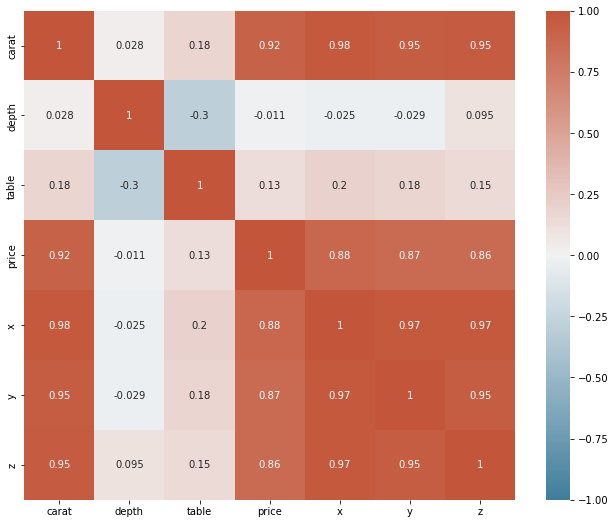

In [9]:
plt.figure(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(data=df.corr(), 
            cmap=cmap, 
            vmin = -1, 
            annot=True)

plt.show()

## Pré-processamento dos dados

### 3. Após o escalonamento das variáveis numéricas, qual é o valor máximo da variável **table**?

Mudar numericamente os valores de forma coordenada.
Como a variável price é o target, ela será desconsiderada.

In [10]:
num = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
cat = ['cut', 'color', 'clarity']

In [11]:
desc_null(df[num])

,count,mean,std,min,25%,50%,75%,max,nullCount,null%
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01,0.0,0.0
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00,0.0,0.0
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00,0.0,0.0
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00,0.0,0.0
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74,0.0,0.0
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90,0.0,0.0
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80,0.0,0.0


In [18]:
dfNum = df[num].drop(columns='price')
dfNum.head()

,carat,depth,table,x,y,z
0,0.23,61.5,55.0,3.95,3.98,2.43
1,0.21,59.8,61.0,3.89,3.84,2.31
2,0.23,56.9,65.0,4.05,4.07,2.31
3,0.29,62.4,58.0,4.20,4.23,2.63
4,0.31,63.3,58.0,4.34,4.35,2.75


In [17]:
# Função para o escalonamento das variáveis contínuas

def feat_scale(x):
    
    # Calcular a mésia de todas as variáveis
    nu =np.mean(x, axis=0)
    
    # Calcular o desvio padrão de todas as variáveis
    signa = np.std(x, axis=0, ddof=1)
    
    # Fazer o escalonamento das variáveis
    xnorm = (x - nu) / signa
    
    return xnorm

In [19]:
dfNum = feat_scale(dfNum)

dfNum.head()

,carat,depth,table,x,y,z
0,-1.198157,-0.174090,-1.099662,-1.587823,-1.536181,-1.571115
1,-1.240350,-1.360726,1.585514,-1.641310,-1.658759,-1.741159
2,-1.198157,-3.384987,3.375631,-1.498677,-1.457382,-1.741159
3,-1.071577,0.454129,0.242926,-1.364959,-1.317293,-1.287708
4,-1.029384,1.082348,0.242926,-1.240155,-1.212227,-1.117663


In [20]:
dfNum.describe()

,carat,depth,table,x,y,z
count,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04
mean,3.774170e-14,5.528923e-13,-3.621533e-14,1.177763e-13,8.638663e-14,-2.522116e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.261446e+00,-1.308748e+01,-6.470013e+00,-5.109073e+00,-5.020884e+00,-5.014510e+00
25%,-8.395154e-01,-5.231005e-01,-6.521325e-01,-9.103164e-01,-8.882717e-01,-8.909378e-01
50%,-2.066190e-01,3.531645e-02,-2.046032e-01,-2.777527e-02,-2.147379e-02,-1.237607e-02
75%,5.106635e-01,5.239313e-01,6.904554e-01,7.210475e-01,7.052356e-01,7.103118e-01
max,8.885992e+00,1.204128e+01,1.680151e+01,4.465161e+00,4.654922e+01,4.004720e+01


### 4. Após a dummyficação das variáveis categóricas, quantas colunas existem em um dataset com somente variáveis desse tipo?

In [12]:
desc_null(df[cat])

,count,unique,top,freq,nullCount,null%
cut,53940,5,Ideal,21551,0,0.0
color,53940,7,G,11292,0,0.0
clarity,53940,8,SI1,13065,0,0.0


In [31]:
dfCat = pd.get_dummies(df[cat], 
                       columns=cat, 
                       drop_first=True)

dfCat.head(3)

,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [33]:
print(f'Existem {dfCat.shape[1]} colunas')

Existem 17 colunas


### 5. A distribuição da resposta **price** é normal e não precisa ser transformada. Essa é uma afirmação verdadeira ou falsa?

Se a resposta não for normal, a capacidade da regressão de extrair as variabilidades é reduzida.

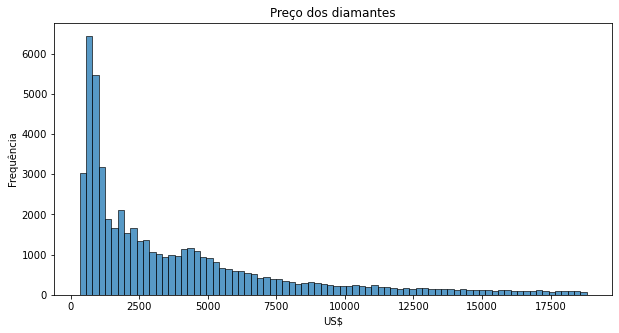

In [36]:
plt.figure(figsize=(10,5))

sns.histplot(data=df,
            x='price')

plt.title("Preço dos diamantes")
plt.ylabel("Frequência")
plt.xlabel("US$")
plt.show()

A variável **price** não é normal, portanto deve ser transformada para aplicação no modelo. Essa afirmação é ***falsa***.

#### Kolmogorov
Distância da distribuição real para distribuição padrão

In [39]:
normKol = stats.kstest(df['price'], cdf='norm')

In [40]:
print(f'Statistic = {normKol.statistic:.3f}, p = {normKol.pvalue:.3f}')

Statistic = 1.000, p = 0.000


#### Shapiro-Wilkis

In [41]:
normShap = stats.shapiro(df['price'])
print(f'Statistic = {normShap.statistic:.3f}, p = {normShap.pvalue:.3f}')

Statistic = 0.798, p = 0.000


C:\Users\bruna\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### D'Agostino k^2 test

In [42]:
normDag = stats.normaltest(df['price'])
print(f'Statistic = {normDag.statistic:.3f}, p = {normDag.pvalue:.3f}')

Statistic = 15096.650, p = 0.000


#### Log de **price**

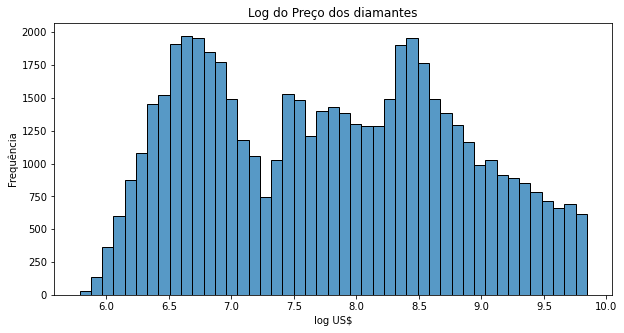

In [45]:
plt.figure(figsize=(10,5))

sns.histplot(data=df,
             x=np.log(df['price']))

plt.title("Log do Preço dos diamantes")
plt.ylabel("Frequência")
plt.xlabel("log US$")
plt.show()

## Ajuste do modelo

### 6. Ao separar o dataset em dois pedaços, o de treinamento e o de teste, quantas linhas possuirá o dataset de teste? 

(Utilize uma proporção de 20% e argumento random_state = 123456)

Dica: concatene os datasets e faça a matriz do modelo antes de fazer a separação entre treinamento e teste.

In [46]:
df_final = pd.concat([dfNum, dfCat, df['price']], axis=1)

df_final.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
0,-1.198157,-0.174090,-1.099662,-1.587823,-1.536181,-1.571115,0,1,0,0,...,0,0,0,0,1,0,0,0,0,326
1,-1.240350,-1.360726,1.585514,-1.641310,-1.658759,-1.741159,0,0,1,0,...,0,0,0,1,0,0,0,0,0,326
2,-1.198157,-3.384987,3.375631,-1.498677,-1.457382,-1.741159,1,0,0,0,...,0,0,0,0,0,1,0,0,0,327
3,-1.071577,0.454129,0.242926,-1.364959,-1.317293,-1.287708,0,0,1,0,...,1,0,0,0,0,0,1,0,0,334
4,-1.029384,1.082348,0.242926,-1.240155,-1.212227,-1.117663,1,0,0,0,...,0,1,0,0,1,0,0,0,0,335


In [47]:
desc_null(df_final)

,count,mean,std,min,25%,50%,75%,max,nullCount,null%
carat,53940.0,3.774170e-14,1.000000,-1.261446,-0.839515,-0.206619,0.510664,8.885992,0.0,0.0
depth,53940.0,5.528923e-13,1.000000,-13.087481,-0.523100,0.035316,0.523931,12.041280,0.0,0.0
table,53940.0,-3.621533e-14,1.000000,-6.470013,-0.652132,-0.204603,0.690455,16.801510,0.0,0.0
x,53940.0,1.177763e-13,1.000000,-5.109073,-0.910316,-0.027775,0.721048,4.465161,0.0,0.0
y,53940.0,8.638663e-14,1.000000,-5.020884,-0.888272,-0.021474,0.705236,46.549216,0.0,0.0
z,53940.0,-2.522116e-13,1.000000,-5.014510,-0.890938,-0.012376,0.710312,40.047205,0.0,0.0
cut_Good,53940.0,9.095291e-02,0.287545,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0
cut_Ideal,53940.0,3.995365e-01,0.489808,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0
cut_Premium,53940.0,2.556730e-01,0.436243,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0
cut_Very Good,53940.0,2.239896e-01,0.416919,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0


Antes de fechar o modelo, necessário criar a coluna **intersect** para depois poder dividir o dataset

In [58]:
# Função para escrever a fórmula

def ols_formula(df, dependent_var, *excluded_rows):
    # Listar o nome das colunas do dataframe
    dfCols = list(df.columns.values)
    
    # Remover a variável dependente
    dfCols.remove(dependent_var)
    
    # Remover as variáveis dependentes:
    for col in excluded_rows:
        dfCols.remove(col)
        
    # Retornar a fórmula:
    return dependent_var + ' ~ ' + ' + '.join(dfCols)

    

In [59]:
ols_formula(df_final, 'price')

'price ~ carat + depth + table + x + y + z + cut_Good + cut_Ideal + cut_Premium + cut_Very Good + color_E + color_F + color_G + color_H + color_I + color_J + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2'

In [60]:
# Verificar correção para o código abaixo - renomear

y, X = pt.dmatrices(ols_formula(df_final, 'price'),
                    data= df_final,
                    return_type='dataframe')

SyntaxError: invalid syntax (<unknown>, line 1)